In [1]:
import os
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# 设定数据路径
data_dir = "./图像数据"  # 请替换成你的数据集路径
batch_size = 32  # 训练批次大小

# 图像预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])

# 加载数据集
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [3]:
# 获取类别索引
normal_indices = [i for i in range(len(dataset)) if dataset.targets[i] == 0]
failure_indices = [i for i in range(len(dataset)) if dataset.targets[i] == 1]

In [4]:
# 使 normal 类样本数量等于 failure 类（2139 张）
selected_normal_indices = random.sample(normal_indices, len(failure_indices))  

# 组合平衡后的索引
balanced_indices = selected_normal_indices + failure_indices
random.shuffle(balanced_indices)

# 重新构造平衡数据集
balanced_dataset = torch.utils.data.Subset(dataset, balanced_indices)

# 使用 random_split 进行 80/20 划分
train_dataset, test_dataset = random_split(balanced_dataset, [0.8, 0.2])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"训练集大小: {len(train_dataset)}，测试集大小: {len(test_dataset)}")

训练集大小: 3423，测试集大小: 855


In [5]:
x_train, y_train = next(iter(train_loader))
print(x_train.shape, y_train.shape)

torch.Size([32, 3, 32, 16]) torch.Size([32])


In [6]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1): # 指定输入通道，输出通道
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
class ResNet_model(nn.Module):
    def __init__(self, num_classes = 2):
        super(ResNet_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1) # 输入为3个通道
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace = True)
        self.layer1 = self._make_layer(8, 16, 2, stride=2) # 输入通道、输出通道、块数
        self.layer2 = self._make_layer(16, 32, 2, stride=2)
        self.layer3 = self._make_layer(32, 32, 2, stride=2)
        self.layer4 = self._make_layer(32, 64, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 26)
        self.fc2 = nn.Linear(26, 2)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) # 4层layer，每个layer有两个残差块
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        feature = self.fc1(x)
        x = self.fc2(feature)
        return x, feature


In [7]:
# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet_model().to(device) # 实例化

In [8]:
summary(model, input_size=(1,3,32,16)) # 可视化网络结构

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_model                             [1, 2]                    --
├─Conv2d: 1-1                            [1, 8, 32, 16]            224
├─BatchNorm2d: 1-2                       [1, 8, 32, 16]            16
├─ReLU: 1-3                              [1, 8, 32, 16]            --
├─Sequential: 1-4                        [1, 16, 16, 8]            --
│    └─ResidualBlock: 2-1                [1, 16, 16, 8]            --
│    │    └─Conv2d: 3-1                  [1, 16, 16, 8]            1,168
│    │    └─BatchNorm2d: 3-2             [1, 16, 16, 8]            32
│    │    └─ReLU: 3-3                    [1, 16, 16, 8]            --
│    │    └─Conv2d: 3-4                  [1, 16, 16, 8]            2,320
│    │    └─BatchNorm2d: 3-5             [1, 16, 16, 8]            32
│    │    └─Sequential: 3-6              [1, 16, 16, 8]            176
│    │    └─ReLU: 3-7                    [1, 16, 16, 8]            --
│    └─

In [9]:
## 训练模型
train_size = len(train_dataset)
test_size = len(test_dataset)
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs, _ = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # 统计训练集的损失
        running_loss += loss.item() * x_train.size(0)
        
        # 统计训练集的准确率
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_train).sum().item()

    # 计算每个 epoch 的训练损失和准确率
    epoch_loss = running_loss / train_size
    epoch_accuracy = 100 * correct / train_size
    
    if epoch % 5 == 0 or epoch == num_epochs-1 :
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')

Epoch [1/30]
Train Loss: 0.6982, Train Accuracy: 53.90%
Epoch [6/30]
Train Loss: 0.6203, Train Accuracy: 65.61%
Epoch [11/30]
Train Loss: 0.5918, Train Accuracy: 69.38%
Epoch [16/30]
Train Loss: 0.5668, Train Accuracy: 70.23%
Epoch [21/30]
Train Loss: 0.5388, Train Accuracy: 73.09%
Epoch [26/30]
Train Loss: 0.5098, Train Accuracy: 74.03%
Epoch [30/30]
Train Loss: 0.4871, Train Accuracy: 74.88%


In [10]:
# model = torch.load("ResNet.pth")

Test Accuracy: 71.23%


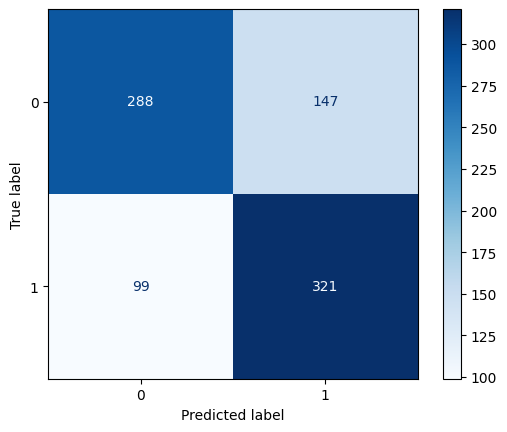

['pre:', 0.6858974358974359, 'recall:', 0.7642857142857142]


In [11]:
# 测试模型
train_size = len(train_dataset)
test_size = len(test_dataset)
model = model.to("cpu")
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to("cpu"), y_test.to("cpu")
        outputs, _ = model(x_test)
        _, y_pred = torch.max(outputs, 1)
        test_correct += (y_pred == y_test).sum().item()

test_accuracy = 100 * test_correct / test_size
print(f'Test Accuracy: {test_accuracy:.2f}%')
y_test, y_pred = y_test.cpu(), y_pred.cpu()
cm = confusion_matrix(y_test, y_pred)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()
## 计算Recall、pre
precision = precision_score(y_test, y_pred, pos_label = 1) # 指定阳性样本（正样本）
recall = recall_score(y_test, y_pred, pos_label = 1)
print([f"pre:", precision, f"recall:", recall])


In [12]:
## 保存模型
# torch.save(model,"ResNet.pth")

In [13]:
## 使用模型提特征
model = model.to(device)
# 获取CNN的训练集、测试集特征
# 重新打包一下train_dataset，批次设置为样本总数，test_dataset一开始批次就是样本总数，不用重新打包
train_loader2 = DataLoader(train_dataset, batch_size=len(train_dataset) ,shuffle = None)

for x_train, y_train in train_loader2:
    x_train, y_train = x_train.to(device), y_train.to(device)
    # x_train = x_train.view(-1,1,500)
    _, train_features = model(x_train) # train_features为 样本数*16的矩阵
    train_label = y_train
    
for x_test, y_test in test_loader:
    x_test, y_test = x_test.to(device), y_test.to(device)
    # x_test = x_test.view(-1,1,500)
    _, test_features = model(x_test)
    test_label = y_test

In [14]:
train_features = train_features.cpu().detach().numpy()
train_label = y_train.cpu().numpy()

test_features = test_features.cpu().detach().numpy()
test_label = y_test.cpu().numpy()

In [18]:
import numpy as np
np.save("train_features.npy", train_features)
np.save("train_label.npy", train_label)
np.save("test_features.npy", test_features)
np.save("test_label.npy", test_label)